In [1]:
import pandas as pd

Ajustar un modelo para el conjunto de datos Saber Pro. El conjunto de datos contiene
información de una población de estudiantes que presentaron los exámenes saber Pro con la
cual se intenta predecir si su nota esta por encima de la media o no.

In [2]:
data=pd.read_csv('./Saber_pro.csv', sep=';')  

n_records=len(data)
n_bajo=len(data[data['nota']=='BAJO LA MEDIA'])
n_sobre=len(data[data['nota']=='SOBRE LA MEDIA'])

#datos faltantes 
data=data.dropna(axis=0)
#display(data.isnull().sum())

print("total:",str(n_records))
print("BAJO LA MEDIA:",n_bajo)
print("SOBRE LA MEDIA:",n_sobre)


total: 77649
BAJO LA MEDIA: 39075
SOBRE LA MEDIA: 38574


Prepare el conjunto de datos elimine los valores incompletos para este conjunto de
datos y transforme las variables categóricas a dummies.

In [3]:
def function_dummies(df):
    df_dummies=df
    colnames=df.columns
    for c in colnames:
        if df[c].dtypes=='object':
            col=  pd.get_dummies(df[c])
            df_dummies[c+"_"+col.columns]=col
            df_dummies = df_dummies.drop(labels=[c],axis=1)
    return (df_dummies)

Y=data['nota']
X=data.drop(labels=['nota'],axis=1)

X_dummies=function_dummies(X)

Y = Y.str.replace('BAJO LA MEDIA','0')
Y = Y.replace('SOBRE LA MEDIA','1')

Separe las poblaciones en entrenamiento y validación en forma aleatoria en 70/30
(genere una semilla aleatoria e indique el valor de la semilla en el software que utilizó).
Indique que cantidad de casos quedaron para cada ambiente.

In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_dummies,Y,
                                               test_size=0.3,
                                               random_state=5)

#display(X_train.isnull().sum())


print("SOBRE LA MEDIA train:",y_train[y_train=='1'].count())
print("BAJO LA MEDIA train:",y_train[y_train=='0'].count())

print("SOBRE LA MEDIA test:",y_test[y_test=='1'].count())
print("BAJO LA MEDIA test:",y_test[y_test=='0'].count())

SOBRE LA MEDIA train: 26944
BAJO LA MEDIA train: 27249
SOBRE LA MEDIA test: 11531
BAJO LA MEDIA test: 11695


Ajuste el mejor modelo posible explotando los parámetros del árbol .

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import  make_scorer
from sklearn.metrics import  auc,accuracy_score,roc_auc_score
from sklearn import tree

param={'criterion':['entropy','gini',],
       'splitter':['best','random'],
       'max_depth':[3,4,5],
       'min_samples_split':[1000,100,500],
       #'min_samples_leaf':[100,300,1000],
      # 'min_weight_fraction_leaf':[0,1],
       #'max_features':[None,'auto','sqrt','log2'],
       #'random_state':[0,1,2],
       'max_leaf_nodes':[10,15,20],
       'min_impurity_decrease':[0.05,0],
       'class_weight':['balanced']
      }
modelo = tree.DecisionTreeClassifier()
auc_scorer = make_scorer(roc_auc_score)

grid_obj = GridSearchCV(modelo, param, 
                        cv=4,
                        n_jobs=-1,
                        scoring=auc_scorer,
                       refit = True, verbose = 3,
                     return_train_score=True,
                       pre_dispatch=2*4)
y_bin_train = label_binarize(y_train, classes=['0', '1'])
grid_obj.fit(X_train, y_bin_train.ravel())




Fitting 4 folds for each of 216 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.7min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['entropy', 'gini'],
                        

In [7]:
display(grid_obj.best_params_)
result=pd.DataFrame(grid_obj.cv_results_)

result.sort_values(['mean_test_score'],
                              ascending=[False]).head()

#corregir result.sort(['mean_test_score'],

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 20,
 'min_impurity_decrease': 0,
 'min_samples_split': 100,
 'splitter': 'random'}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
213       0.525431      0.005299         0.024415        0.001017   
203       0.497720      0.002463         0.027729        0.004922   
199       0.503992      0.008767         0.025204        0.000648   
107       0.505635      0.004389         0.036936        0.009146   
103       0.499988      0.008346         0.038987        0.004040   

    param_class_weight param_criterion param_max_depth param_max_leaf_nodes  \
213           balanced            gini               5                   20   
203           balanced            gini               5                   15   
199           balanced            gini               5                   15   
107           balanced         entropy               5                   20   
103           balanced         entropy               5                   20   

    param_min_impurity_decrease param_min_samples_split  ...  \
213                           0                     100  ...   
203                           0                     500  ...   
199                           0                    1000  ...   
107                           0                     500  ...   
103                           0                    1000  ...   

    split3_test_score mean_test_score  std_test_score  rank_test_score  \
213          0.659821        0.652836        0.004713                1   
203          0.657199        0.652036        0.003886                2   
199          0.659749        0.650560        0.005983                3   
107          0.659749        0.650185        0.006219                4   
103          0.659749        0.649976        0.007173                5   

     split0_train_score  split1_train_score  split2_train_score  \
213            0.658016            0.657341            0.642797   
203            0.657871            0.656107            0.640553   
199            0.652520            0.654894            0.646573   
107            0.652520            0.654894            0.641411   
103            0.657871            0.654894            0.640446   

     split3_train_score  mean_train_score  std_train_score  
213            0.654412          0.653141         0.006124  
203            0.652618          0.651787         0.006756  
199            0.654292          0.652070         0.003291  
107            0.654292          0.650779         0.005479  
103            0.654292          0.651876         0.006737  

[5 rows x 25 columns]

In [ ]:
#entrenar arbol
from sklearn import tree

mejores_parametros={'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 15,
 'min_impurity_decrease': 0,
 'min_impurity_split': 0.4,
 'min_samples_split': 1000,
 'splitter': 'random'}

modelo=tree.DecisionTreeClassifier(**mejores_parametros)
modelo.fit(X_train,y_train)



In [ ]:
from scipy import stats
def my_roc_auc(y_real,y_pred): 
    y_real = label_binarize(y_real, classes=['0', '1'])
    y_pred = label_binarize(y_pred, classes=['0', '1'])
    fpr, tpr, _ = roc_curve(y_real.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    return (roc_auc)

def my_ensamble(n,x_train,y_train,parametros):
    i=0
    vector_modelos=[]
    variables_modelos=[]
    while i<n:
        m=tree.DecisionTreeClassifier(**parametros)
        m.fit(x_train,y_train)
        variables=pd.DataFrame()
        variables['importancia']=m.feature_importances_
        variables['variable']=x_train.columns
        variables.index=variables['importancia']
        y_pred=m.predict(X_test[x_train.columns])
        area=my_roc_auc(y_test, y_pred)
        x=x_train.drop(labels=[variables['variable'][variables['importancia'].max()]],axis=1)
        vector_modelos.append(m)
        variables_modelos.append(variables['variable'][variables['importancia'].max()])
        x_train=x 
        print(variables['variable'][variables['importancia'].max()],area) 
        i=i+1
    return (vector_modelos,variables_modelos)

mejores_parametros={'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 15,
 'min_impurity_decrease': 0,
 #'min_impurity_split': 0.4,
 'min_samples_split': 1000,
 'splitter': 'random'}
modelos,var=my_ensamble(11,X_train,y_train,mejores_parametros)

def my_predict(modelos,variables,x_pred):
    y_pred=[]
    j=0
    x=x_pred.copy()
    votos=pd.DataFrame()
    for m in modelos: 
        votos[variables[j]]=m.predict(x)
        x=x.drop(labels=[variables[j]],axis=1)
        j=j+1
    votos=votos.transpose()
    predict=[]
    for c in votos.columns:
        predict.append(votos[c].mode()[0])
    return (predict)


    

#variables=pd.DataFrame()
#variables['importancia']=modelo.feature_importances_
#variables['variable']=X_train.columns
#variables.index=variables['importancia']
#variables['variable'][variables['importancia'].max()

In [ ]:
y_pred=my_predict(modelos,var,X_test) 
display('Test:',confusion_matrix(y_test,y_pred))
print("accuracy test:",accuracy_score(y_test, y_pred))
my_roc(y_test, y_pred)

In [ ]:
from xgboost import XGBClassifier

params = {'objective':'binary:logistic',
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 3, 'alpha': 10,
          'n_estimators':500}

modelo = XGBClassifier(**params)
modelo.fit(X_train, y_train)


In [1]:



from sklearn.ensemble import RandomForestClassifier


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)

modelo=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=1500, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

modelo=modelo.fit(X_train, y_train)




KeyboardInterrupt: 

Visualizar el árbol generado y explicar dos reglas de este que mas le llamen la
atención.

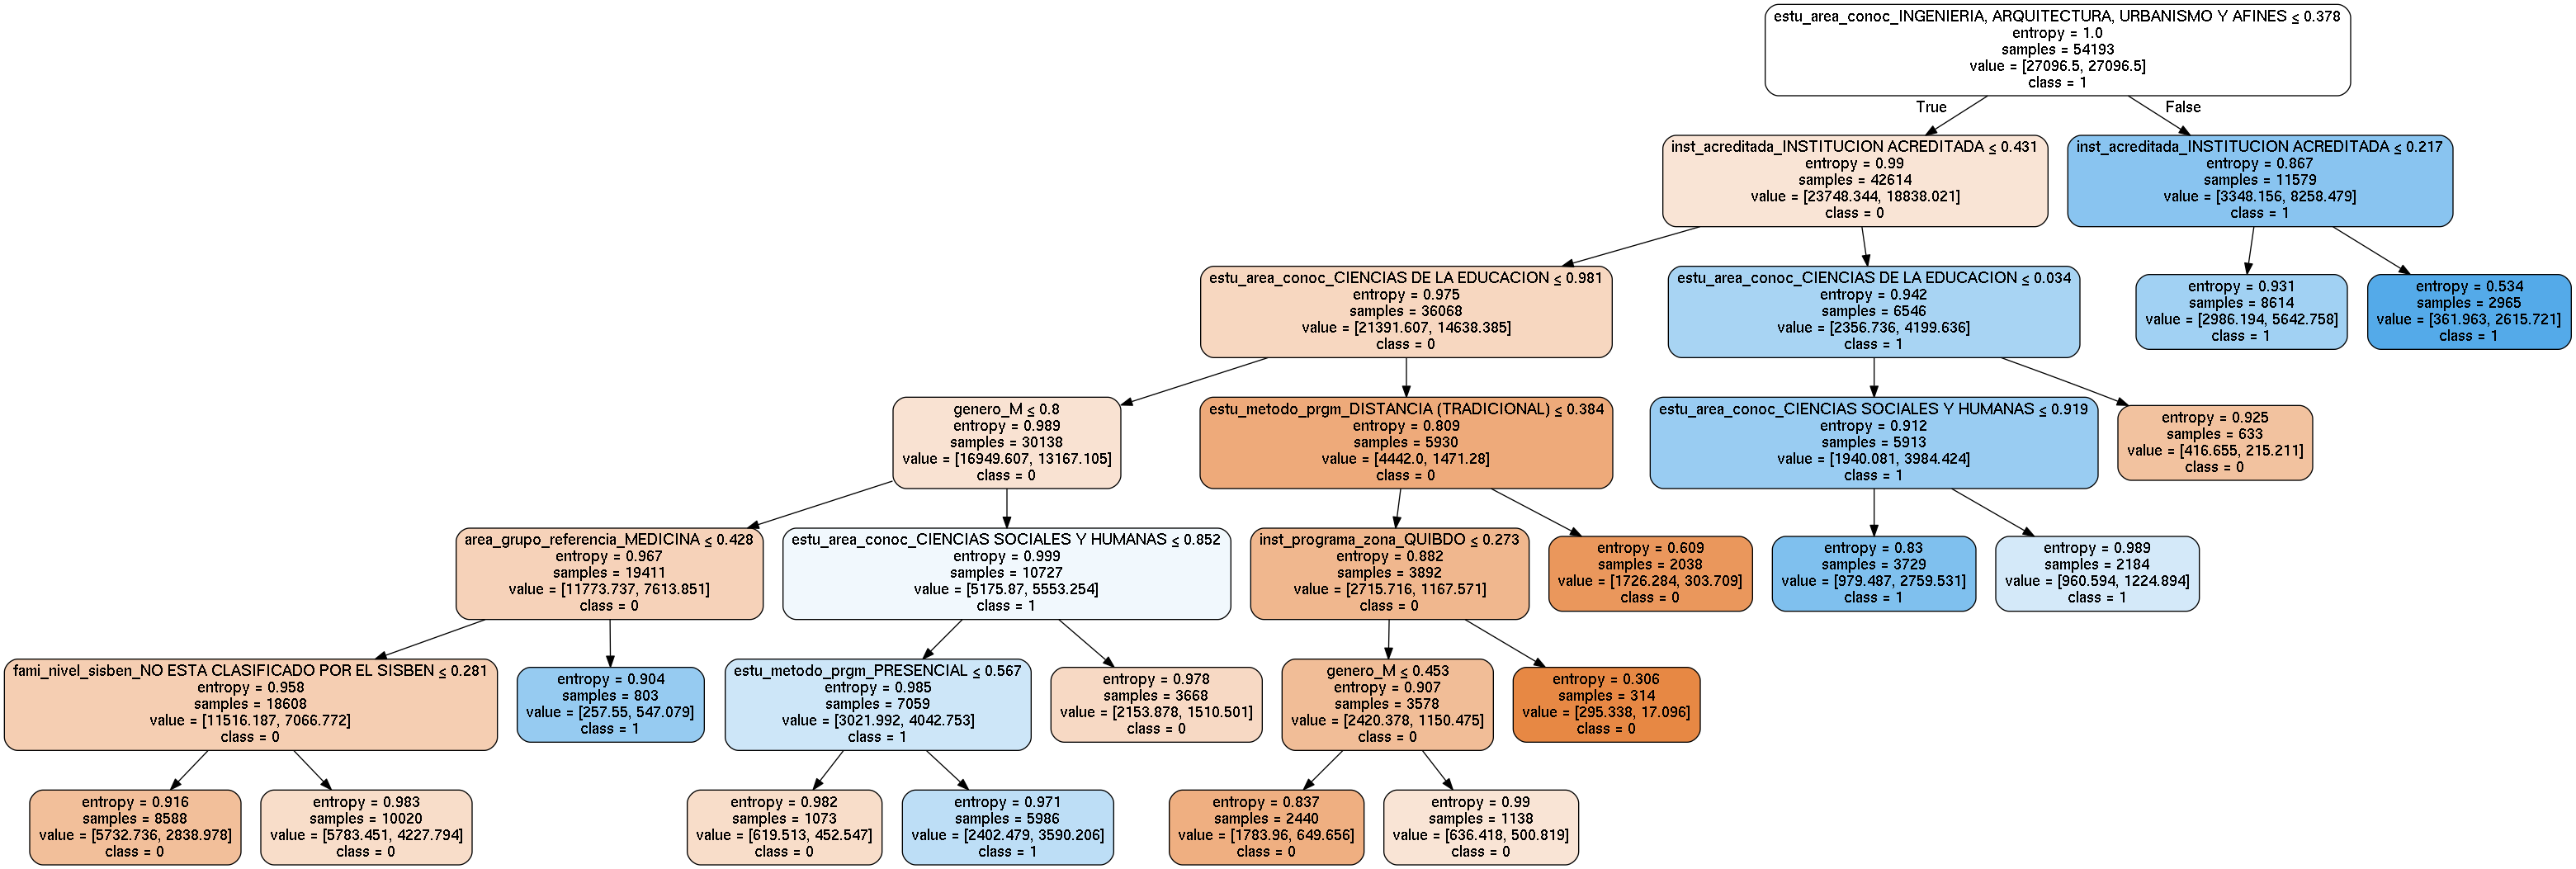

In [35]:
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image 
#pip install graphviz
#pip install pydotplus
dot_data = StringIO()

feature_cols=X_train.columns
export_graphviz(modelo, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('arbol.png')
Image(graph.create_png())

Obtener la matriz de confusión tanto para el ambiente de entrenamiento como de
validación.

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,classification_report


#predict test
y_pred_test=modelo.predict(X_test)
#predict train
y_pred_train=modelo.predict(X_train)


display('Test:',confusion_matrix(y_test,y_pred_test))
display('Train:',confusion_matrix(y_train,y_pred_train))


'Test:'

array([[8870, 2825],
       [5233, 6298]])

'Train:'

array([[20660,  6589],
       [12195, 14749]])

Calcular la accuracy en ambiente de entrenamiento y validación.

In [105]:
print("accuracy test:",accuracy_score(y_test, y_pred_test))
print("accuracy train:",accuracy_score(y_train, y_pred_train))

accuracy test: 0.65306122449
accuracy train: 0.653386968797


Calcular el AUC y el gráfico ROC en entrenamiento y validación.

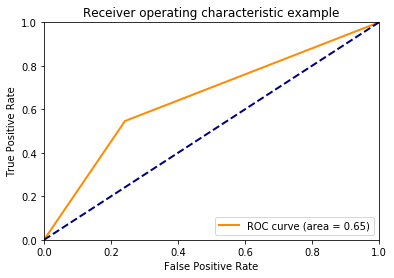

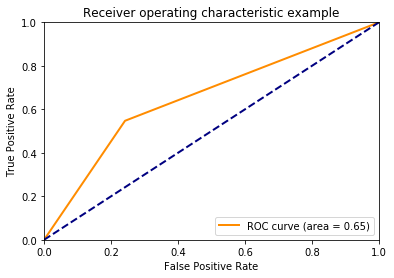

0.65279377870455535

In [106]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def my_roc(y_real,y_pred): 
    y_real = label_binarize(y_real, classes=['0', '1'])
    y_pred = label_binarize(y_pred, classes=['0', '1'])
    fpr, tpr, _ = roc_curve(y_real.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return (roc_auc)

my_roc(y_test, y_pred_test)
my_roc(y_train, y_pred_train)

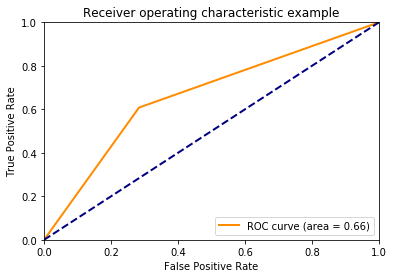

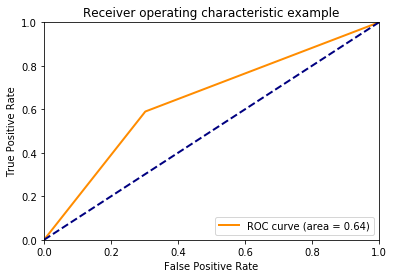

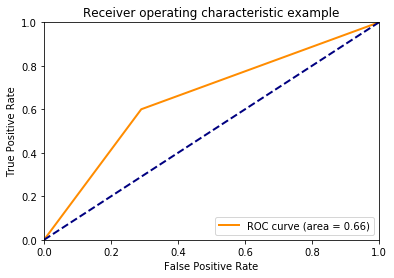

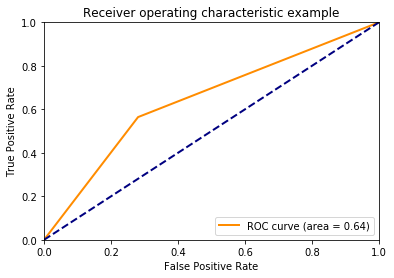

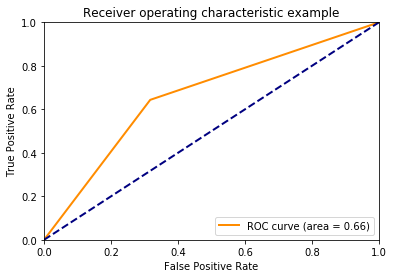

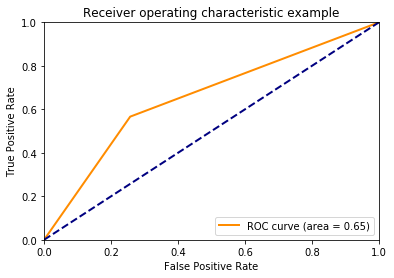

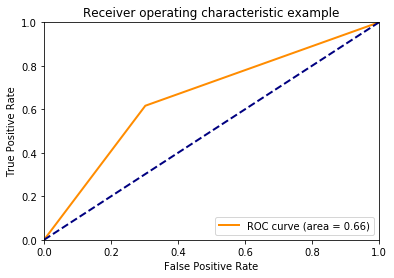

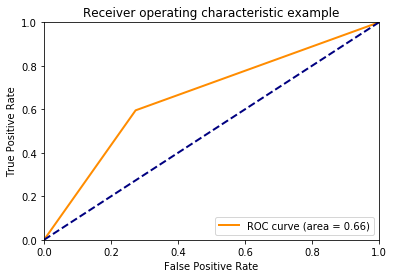

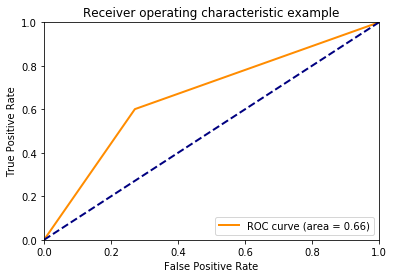

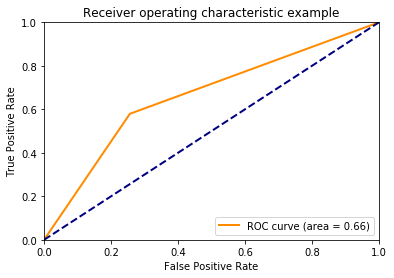

0.656537734554


In [107]:
from sklearn.model_selection import StratifiedKFold

def validazacion_cruzada(x_train,y_train,kfolds,model):
    cv = StratifiedKFold(n_splits=kfolds,shuffle=False)
    prom_auc=[]
    for train,test in cv.split(x_train,y_train):
    
        modelo=model.fit(x_train.iloc[train],y_train.iloc[train])
        y_pred_modelo=modelo.predict(x_train.iloc[test])
        prom_auc.append(my_roc(y_train.iloc[test], 
                                    y_pred_modelo))
    return(prom_auc)

auc_vec=validazacion_cruzada(X_train,y_train,10,modelo)
print(sum(auc_vec)/len(auc_vec))    
    

Selecciones el 25% de los individuos en el ambiente de validación de acuerdo a la
siguiente lógica. Entregue los resultados indicados:

Al azar e indique la cantidad de individuos que están por encima de la media.

In [108]:
X_test_75, X_25, y_test_75, y_25 = train_test_split(X_test, 
                             y_test, 
                            test_size = 0.25, 
                            random_state = 0)
    
#cantidad de individuos >50k al azar
print ("total 25%",y_25.count())
print("Sobre la media test 25% azar",y_25[y_25=='1'].count())


total 25% 5807
Sobre la media test 25% azar 2851


Utilizando el modelo desarrollado en el punto 1.1.2 e indique la cantidad de
individuos que están por encima de la media.

In [109]:
probs_test = modelo.predict_proba(X_test)  
data_set_test=X_test.copy()

data_set_test['predicho']=y_pred_test
data_set_test['predicho_prob_1']=probs_test[:,1]
data_set_test['predicho_prob_0']=probs_test[:,0]
data_set_test['real']=y_test
display(data_set_test.head(5))

estu_edad_examen  num_estu_zona  num_instituciones_zona  genero_F  \
35779                25          13519                      56         1   
66865                27          33544                      73         1   
25794                21          16500                      78         0   
1019                 22          16500                      78         1   
60625                36          33544                      73         1   

       genero_M  estado_civil_CASADO(A)  \
35779         0                       0   
66865         0                       0   
25794         1                       0   
1019          0                       0   
60625         0                       1   

       estado_civil_SEPARADO(A) Y/O DIVORCIADO  estado_civil_SOLTERO(A)  \
35779                                        0                        1   
66865                                        0                        1   
25794                                        0                        1   
1019                                         0                        1   
60625                                        0                        0   

       estado_civil_UNION LIBRE  estado_civil_VIUDO(A)          ...            \
35779                         0                      0          ...             
66865                         0                      0          ...             
25794                         0                      0          ...             
1019                          0                      0          ...             
60625                         0                      0          ...             

       fami_ing_fmliar_mensual_TRES SALARIOS  \
35779                                      0   
66865                                      1   
25794                                      0   
1019                                       1   
60625                                      0   

       fami_ing_fmliar_mensual_UN SALARIO  estu_trabaja_NO  \
35779                                   0                0   
66865                                   0                0   
25794                                   0                1   
1019                                    0                1   
60625                                   0                1   

       estu_trabaja_SI, PARA ADQUIRIR EXPERIENCIA Y/O RECURSOS PARA SUS GASTOS PERSONALES  \
35779                                                  0                                    
66865                                                  0                                    
25794                                                  0                                    
1019                                                   0                                    
60625                                                  0                                    

       estu_trabaja_SI, PARA CONTRIBUIR A PAGAR SU MATRICULA Y/O LOS GASTOS DEL HOGAR  \
35779                                                  1                                
66865                                                  1                                
25794                                                  0                                
1019                                                   0                                
60625                                                  0                                

       estu_trabaja_SI, POR SER PRACTICA OBLIGATORIA DEL PROGRAMA DE ESTUDIOS  \
35779                                                  0                        
66865                                                  0                        
25794                                                  0                        
1019                                                   0                        
60625                                                  0                        

       predicho  predicho_prob_1  predicho_prob_0  real  
35779         0         0.492112         0.507888   

In [379]:
y_25_modelo=data_set_test.sort(['predicho_prob_1'],
                              ascending=[False])[1:y_25.count()]

print("SOBRE LA MEDIA k 25% modelo:",
      len(y_25_modelo[y_25_modelo['real']=='1']))


SOBRE LA MEDIA k 25% modelo: 4266


Lea el conjunto de datos Saber_pro_predecir.csv utilice el modelo generado para
predecir los registros de este archivo, genere archivo.csv con los resultados de las
predicciones de su modelo y enviarlo por vía mail.

In [23]:
import numpy as np
df_predecir=pd.read_csv('./Saber_pro_predecir.csv', sep=';')  


#display(df_predecir.describe())


display(df_predecir['estu_pers_cargo'].unique())
display(df_predecir['estu_pje_creditos'].unique())
display(df_predecir['eco_condicion_vive'].unique())



display(df_predecir["estu_pers_cargo"].mode()[0])

df_predecir["estu_edad_examen"]=df_predecir["estu_edad_examen"].replace(np.nan,df_predecir["estu_edad_examen"].mean())
    

#df_predecir["estu_pers_cargo"]=df_predecir["estu_pers_cargo"].replace(np.nan, df_predecir["estu_pers_cargo"].mode())

df_predecir["estu_pers_cargo"].fillna(value=
                                      df_predecir["estu_pers_cargo"].mode()[0],
                                      inplace =True)


df_predecir["estu_pje_creditos"].fillna(value=df_predecir["estu_pje_creditos"].mode()[0],inplace =True)
df_predecir["eco_condicion_vive"].fillna(value=df_predecir["eco_condicion_vive"].mode()[0],inplace =True)


#display(df_predecir.isnull().sum())
df_predecir=function_dummies(df_predecir)
#display(df_predecir.isnull().sum())
#display(df_predecir.head(3))


array(['SI', 'NO', nan], dtype=object)

array(['MAS DE 90%', 'ENTRE 81% Y 90%', 'ENTRE 75% Y 80%', 'MENOS DEL 75%',
       'NO SIGUE SISTEMA DE CREDITOS', nan], dtype=object)

array(['SIN HACINAMIENTO', nan, 'HACINAMIENTO MEDIO',
       'HACINAMIENTO CRITICO'], dtype=object)

'NO'

In [32]:
display(len(X_train.columns))
display(len(df_predecir.columns))
#df_predecir[X_train.columns].head()



239

237

In [34]:
i=0
len(df_predecir.columns)
len(X_train.columns)
#df_predecir[]


while i<len(X_train.columns):
    if X_train.columns[i] not in df_predecir.columns:
        df_predecir[X_train.columns[i]]=0
    i=i+1
df_predecir[X_train.columns].head()

estu_edad_examen  num_estu_zona  num_instituciones_zona  genero_F  \
0                28          33544                      73         0   
1                20          16500                      78         1   
2                23          13345                      64         1   
3                34          13733                      64         1   
4                26          16500                      78         1   

   genero_M  estado_civil_CASADO(A)  estado_civil_SEPARADO(A) Y/O DIVORCIADO  \
0         1                       1                                        0   
1         0                       0                                        0   
2         0                       0                                        0   
3         0                       0                                        0   
4         0                       0                                        0   

   estado_civil_SOLTERO(A)  estado_civil_UNION LIBRE  estado_civil_VIUDO(A)  \
0                        0                         0                      0   
1                        1                         0                      0   
2                        1                         0                      0   
3                        1                         0                      0   
4                        1                         0                      0   

           ...            fami_ing_fmliar_mensual_CUATRO SALARIOS  \
0          ...                                                  0   
1          ...                                                  0   
2          ...                                                  0   
3          ...                                                  0   
4          ...                                                  0   

   fami_ing_fmliar_mensual_DOS SALARIOS  \
0                                     1   
1                                     0   
2                                     0   
3                                     1   
4                                     0   

   fami_ing_fmliar_mensual_SEIS SALARIOS  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   fami_ing_fmliar_mensual_SIETE SALARIOS  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   fami_ing_fmliar_mensual_TRES SALARIOS  fami_ing_fmliar_mensual_UN SALARIO  \
0                                      0                                   0   
1                                      1                                   0   
2                                      1                                   0   
3                                      0                                   0   
4                                      1                                   0   

   estu_trabaja_NO  \
0                0   
1                1   
2                0   
3                0   
4                0   

   estu_trabaja_SI, PARA ADQUIRIR EXPERIENCIA Y/O RECURSOS PARA SUS GASTOS PERSONALES  \
0                                                  0                                    
1                                                  0                                    
2                                                  0                                    
3                                                  0                                    
4                                                  0                                    

   estu_trabaja_SI, PARA CONTRIBUIR A PAGAR SU MATRICULA Y/O LOS GASTOS DEL HOGAR  \
0                                                  1                                
1                                                  0                                


In [44]:
y_modelo=modelo.predict(df_predecir[X_train.columns])
y_modelo

array(['1', '0', '0', ..., '0', '0', '1'], dtype=object)

In [50]:
resultado=pd.DataFrame()
resultado['y']=y_modelo
resultado['y'].describe()
#resultado['y'].mode()
resultado.to_csv("./mateo.csv",index=False)

In [382]:
y_pred=my_predict(modelos,var,df_predecir[X_train.columns]) 

In [383]:
len(y_modelo)

19413

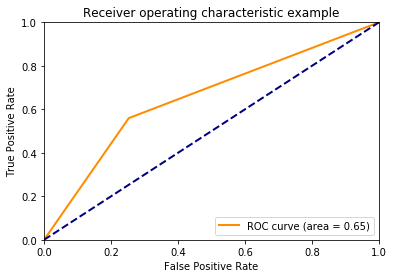

0.65333682402315918

In [384]:
y_saber=pd.read_csv('./real.csv')  
y_saber.head()

Y1=y_saber['nota']

Y1 = Y1.str.replace('BAJO LA MEDIA','0')
Y1 = Y1.replace('SOBRE LA MEDIA','1')

my_roc(Y1,y_modelo)
